In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras import metrics

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from DataProcess import *

In [4]:
class dataprocess_cnn(dataprocess):
    def __init__(self,subj_filename,T=512,stride=512,redact=1000):
        """
        type subject_filename: str --the filepath of .dat data file for one subject
        T -- number of samples on which to calculate features
        stride -- gap between chunks of data onwhich features are calculated
        redact -- number of samples to remove from the start and end of each activity 
        
        """
        self.subj_filename=subj_filename
        
        #Get the resting and maximum heartrates for that subject
        subject_index = int(self.subj_filename.split('/')[-1].split('.')[0][-1])
        self.HR_rest = HR_lim[subject_index][0]
        self.HR_max = HR_lim[subject_index][1]
        
        self.feat_labels=None
        self.chunks=self.preprocess(redact)
        self.data_segmented=self.segmentation(self.chunks,T,stride)
        
    def segmentation(self,chunks,T=512,stride=512):
        """
        type chunks:List[array] --continuous time blocks of data, each array should have 33 columns
        return type: array --each row corresponds to features calculated on a segment of length T. Features are extracted by
        feature_extraction. Consecutive rows are calculated on segments which are one stride apart.
        """
        data_segmented=np.empty(0)
        for chunk in chunks:
            imax=(len(chunk)-T)//stride
            for i in range(imax+1):
                arr=chunk[i*stride:i*stride+T][None,:,:]
                data_segmented=np.vstack((data_segmented,arr)) if data_segmented.size else arr
        return data_segmented

In [5]:
for subj_n in range(1,10):
    #load the data
    subj_filename='C:/Users/lt/Desktop/DSW2018/PAMAP2_Dataset/Protocol/subject10'+str(subj_n)+'.dat'
    dp=dataprocess_cnn(subj_filename)
    np.save('data_cnn'+str(subj_n)+'.npy', (col_sublabels,dp.data_segmented))

In [6]:
datalabels=[]
for i in range(1,10):
    feature_names,datalabelsi=np.load('data_cnn'+str(i)+'.npy')
    datalabels.append(datalabelsi)

datalabels=np.vstack(datalabels)

In [7]:
X_all=datalabels[:,:,2:]
y_all=datalabels[:,0,1]

#convert activity id to lie within range(12)
act_list=np.unique(datalabels[:,0,1])
y_all2=np.nonzero(y_all[:,np.newaxis]==act_list)[1]

# convert labels to class matrix, one-hot-encoding
Y_all = np_utils.to_categorical(y_all2,12)
# split in train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.reshape(len(X_train)*512,31))

X_trainnorm=(X_train-scaler.mean_)/scaler.scale_
X_testnorm=(X_test-scaler.mean_)/scaler.scale_

In [9]:
model = Sequential()
model.add(Convolution1D(16, 3, activation='relu', input_shape=(512,31)))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
history=model.fit(X_trainnorm, Y_train, validation_data=(X_testnorm,Y_test), epochs=10, batch_size=16)

Train on 2664 samples, validate on 666 samples
Epoch 1/10
2664/2664 [==============================] - 5s 2ms/step - loss: 1.3086 - acc: 0.6284 - val_loss: 0.6531 - val_acc: 0.7958
Epoch 2/10
2664/2664 [==============================] - 2s 674us/step - loss: 0.4422 - acc: 0.8697 - val_loss: 0.3234 - val_acc: 0.9099
Epoch 3/10
2664/2664 [==============================] - 2s 674us/step - loss: 0.1688 - acc: 0.9587 - val_loss: 0.1981 - val_acc: 0.9399
Epoch 4/10
2664/2664 [==============================] - 2s 674us/step - loss: 0.0844 - acc: 0.9745 - val_loss: 0.1960 - val_acc: 0.9535
Epoch 5/10
2664/2664 [==============================] - 2s 674us/step - loss: 0.0449 - acc: 0.9884 - val_loss: 0.1698 - val_acc: 0.9535
Epoch 6/10
2664/2664 [==============================] - 2s 680us/step - loss: 0.0247 - acc: 0.9951 - val_loss: 0.1596 - val_acc: 0.9610
Epoch 7/10
2664/2664 [==============================] - 2s 668us/step - loss: 0.0112 - acc: 0.9989 - val_loss: 0.1400 - val_acc: 0.9730
Epo

In [11]:
model = Sequential()
 
model.add(Convolution1D(64, 3, activation='relu', input_shape=(512,31)))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Convolution1D(64, 3,activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5)) 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(model.evaluate(X_trainnorm,Y_train))
        return

In [13]:
model.evaluate(X_trainnorm,Y_train)

2664/2664 [==============================] - 1s 352us/step


[2.6044303211005957, 0.07582582582582582]

In [14]:
history=LossHistory()
historyepoch=model.fit(X_trainnorm, Y_train, validation_data=(X_testnorm,Y_test), epochs=20, batch_size=16,callbacks=[history])

Train on 2664 samples, validate on 666 samples
Epoch 1/20
2664/2664 [==============================] - 1s 264us/step
Epoch 2/20
2664/2664 [==============================] - 1s 276us/step
Epoch 3/20
2664/2664 [==============================] - 1s 270us/step
Epoch 4/20
2664/2664 [==============================] - 1s 264us/step
Epoch 5/20
2664/2664 [==============================] - 1s 276us/step
Epoch 6/20
2664/2664 [==============================] - 1s 281us/step
Epoch 7/20
2664/2664 [==============================] - 1s 276us/step
Epoch 8/20
2664/2664 [==============================] - 1s 276us/step
Epoch 9/20
2664/2664 [==============================] - 1s 276us/step
Epoch 10/20
2664/2664 [==============================] - 1s 293us/step
Epoch 11/20
2664/2664 [==============================] - 1s 281us/step
Epoch 12/20
2664/2664 [==============================] - 1s 281us/step
Epoch 13/20
2664/2664 [==============================] - 1s 275us/step
Epoch 14/20
2664/2664 [================

In [15]:
history.losses=np.array(history.losses)

In [16]:
#loss=historyepoch.history['loss']
loss=history.losses[:,0]
val_loss=historyepoch.history['val_loss']
#acc=historyepoch.history['acc']
acc=history.losses[:,1]
val_acc=historyepoch.history['val_acc']

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

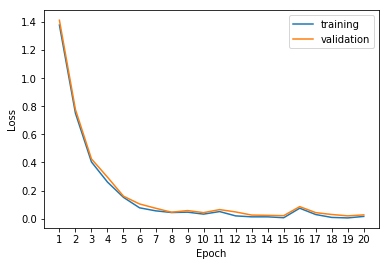

In [18]:
plt.plot(loss)
plt.plot(val_loss)
plt.legend(('training','validation'))
plt.ylabel('Loss');
plt.xlabel('Epoch');
plt.xticks(np.arange(20),np.arange(20)+1);

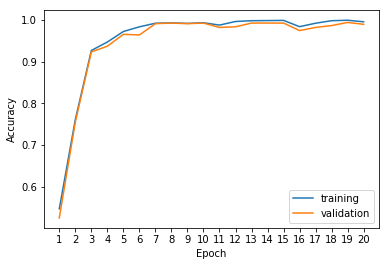

In [19]:
plt.plot(acc)
plt.plot(val_acc)
plt.legend(('training','validation'))
plt.ylabel('Accuracy');
plt.xlabel('Epoch');
plt.xticks(np.arange(20),np.arange(20)+1);

CNN loso

In [21]:
mean_scores=[]
for iout in range(0,9):
    datalabels=[]
    for i in range(1,10):
        feature_names,datalabelsi=np.load('data_cnn'+str(i)+'.npy')
        datalabels.append(datalabelsi)
        
    testdatalabels=datalabels.pop(iout)
    datalabels=np.vstack(datalabels)

    X_all=datalabels[:,:,2:]
    y_all=datalabels[:,0,1]

    X_test=testdatalabels[:,:,2:]
    y_test=testdatalabels[:,0,1]

    #convert activity id to lie within range(12)
    act_list=np.unique(datalabels[:,0,1])
    y_all2=np.nonzero(y_all[:,np.newaxis]==act_list)[1]
    y_test2=np.nonzero(y_test[:,np.newaxis]==act_list)[1]

    # convert labels to class matrix, one-hot-encoding
    Y_all = np_utils.to_categorical(y_all2,12)
    Y_test = np_utils.to_categorical(y_test2,12)
    # split in train and test set
    #X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2)
    X_train, Y_train=X_all,Y_all

    scaler = StandardScaler()
    scaler.fit(X_train.reshape(len(X_train)*512,31))

    X_trainnorm=(X_train-scaler.mean_)/scaler.scale_
    X_testnorm=(X_test-scaler.mean_)/scaler.scale_

    model = Sequential()

    model.add(Convolution1D(64, 3, activation='relu', input_shape=(512,31)))
    model.add(MaxPooling1D(3))
    model.add(Dropout(0.5))
    model.add(Convolution1D(64, 3,activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Dropout(0.5)) 
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(12, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(X_trainnorm, Y_train, validation_data=(X_testnorm,Y_test), epochs=20, batch_size=16)

    mean_scores.append(model.evaluate(X_testnorm,Y_test))

Train on 2904 samples, validate on 426 samples
Epoch 1/20
2904/2904 [==============================] - 3s 993us/step - loss: 2.1095 - acc: 0.2831 - val_loss: 1.6488 - val_acc: 0.4484
Epoch 2/20
2904/2904 [==============================] - 2s 834us/step - loss: 1.4166 - acc: 0.4855 - val_loss: 1.3093 - val_acc: 0.5258
Epoch 3/20
2904/2904 [==============================] - 2s 818us/step - loss: 0.9188 - acc: 0.6298 - val_loss: 1.1233 - val_acc: 0.6362
Epoch 4/20
2904/2904 [==============================] - 2s 818us/step - loss: 0.7197 - acc: 0.7197 - val_loss: 1.2874 - val_acc: 0.6479
Epoch 5/20
2904/2904 [==============================] - 2s 823us/step - loss: 0.4889 - acc: 0.8264 - val_loss: 1.1724 - val_acc: 0.7042
Epoch 6/20
2904/2904 [==============================] - 2s 828us/step - loss: 0.3160 - acc: 0.8871 - val_loss: 0.7751 - val_acc: 0.8005
Epoch 7/20
2904/2904 [==============================] - 2s 796us/step - loss: 0.2569 - acc: 0.9067 - val_loss: 1.7484 - val_acc: 0.7394
E

In [22]:
mean_scores

[[1.1393674887732006, 0.7934272300469484],
 [2.7831354453905175, 0.5982339955849889],
 [0.4494135926849255, 0.9075342465753424],
 [0.2853063193733601, 0.9197994987468672],
 [1.6776624583862179, 0.7478813569424516],
 [0.43392052708151563, 0.9120370370370371],
 [0.12262831396401339, 0.964824120603015],
 [1.8497057936588934, 0.5844444444444444],
 [0.507929265499115, 0.625]]

In [23]:
np.mean(np.array(mean_scores)[:-1,1])

0.8035227412476369

CNN continuous train test split

In [30]:
class dataprocess_cnn2(dataprocess_cnn):
    def __init__(self,subj_filename,T=512,stride=512,redact=1000):
        """
        type subject_filename: str --the filepath of .dat data file for one subject
        T -- number of samples on which to calculate features
        stride -- gap between chunks of data onwhich features are calculated
        redact -- number of samples to remove from the start and end of each activity 
        
        """
        self.subj_filename=subj_filename
        
        #Get the resting and maximum heartrates for that subject
        subject_index = int(self.subj_filename.split('/')[-1].split('.')[0][-1])
        self.HR_rest = HR_lim[subject_index][0]
        self.HR_max = HR_lim[subject_index][1]
        
        self.feat_labels=None
        self.chunks=self.preprocess(redact)
#        self.fc = FC.FeatureCalc()
        self.train_segmented,self.test_segmented=self.segmentation(self.chunks,T,stride)
#        self.df=pd.DataFrame(self.data_segmented,columns=self.feat_labels)
    def segmentation(self,chunks,T=512,stride=512):
        """
        type chunks:List[array] --continuous time blocks of data, each array should have 33 columns
        return type: array --each row corresponds to features calculated on a segment of length T. Features are extracted by
        feature_extraction. Consecutive rows are calculated on segments which are one stride apart.
        """
        train_segmented=np.empty(0)
        test_segmented=np.empty(0)
        for chunk in chunks:
            imax=(len(chunk)-T)//stride
            for i in range(imax+1):
                arr=chunk[i*stride:i*stride+T][None,:,:]
                if i<=0.8*imax:
                    train_segmented=np.vstack((train_segmented,arr)) if train_segmented.size else arr
                else:
                    test_segmented=np.vstack((test_segmented,arr)) if test_segmented.size else arr
        return train_segmented,test_segmented

In [31]:
dp={}
for subj_n in range(1,10):
    #load the data
    subj_filename='C:/Users/lt/Desktop/DSW2018/PAMAP2_Dataset/Protocol/subject10'+str(subj_n)+'.dat'
    dp[subj_n]=dataprocess_cnn2(subj_filename)

In [32]:
traindatalabels=[]
testdatalabels=[]
for i in range(1,10):
    feature_names,traindatalabelsi,testdatalabelsi=(col_sublabels,dp[i].train_segmented,dp[i].test_segmented)
    traindatalabels.append(traindatalabelsi)
    testdatalabels.append(testdatalabelsi)
traindatalabels=np.vstack(traindatalabels)
testdatalabels=np.vstack(testdatalabels)

In [33]:
X_all=traindatalabels[:,:,2:]
y_all=traindatalabels[:,0,1]

X_test=testdatalabels[:,:,2:]
y_test=testdatalabels[:,0,1]

#convert activity id to lie within range(12)
act_list=np.unique(traindatalabels[:,0,1])
y_all2=np.nonzero(y_all[:,np.newaxis]==act_list)[1]
y_test2=np.nonzero(y_test[:,np.newaxis]==act_list)[1]

# convert labels to class matrix, one-hot-encoding
Y_all = np_utils.to_categorical(y_all2,12)
Y_test = np_utils.to_categorical(y_test2,12)
# split in train and test set
#X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2)
X_train, Y_train=X_all,Y_all


In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.reshape(len(X_train)*512,31))

X_trainnorm=(X_train-scaler.mean_)/scaler.scale_
X_testnorm=(X_test-scaler.mean_)/scaler.scale_

In [35]:
model = Sequential()
model.add(Convolution1D(8, 3, activation='relu',kernel_initializer='glorot_normal', input_shape=(512,31)))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Convolution1D(8, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
hist=model.fit(X_trainnorm, Y_train, validation_data=(X_testnorm,Y_test), epochs=16, batch_size=16)

Train on 2644 samples, validate on 686 samples
Epoch 1/16
2644/2644 [==============================] - 3s 1ms/step - loss: 2.1773 - acc: 0.2840 - val_loss: 1.6091 - val_acc: 0.5160
Epoch 2/16
2644/2644 [==============================] - 2s 839us/step - loss: 1.1765 - acc: 0.5726 - val_loss: 1.0931 - val_acc: 0.6327
Epoch 3/16
2644/2644 [==============================] - 2s 839us/step - loss: 0.7547 - acc: 0.7235 - val_loss: 0.8005 - val_acc: 0.7376
Epoch 4/16
2644/2644 [==============================] - 2s 874us/step - loss: 0.5397 - acc: 0.8026 - val_loss: 0.6292 - val_acc: 0.8017
Epoch 5/16
2644/2644 [==============================] - 2s 874us/step - loss: 0.4043 - acc: 0.8627 - val_loss: 0.5555 - val_acc: 0.8513
Epoch 6/16
2644/2644 [==============================] - 2s 880us/step - loss: 0.3110 - acc: 0.8911 - val_loss: 0.4225 - val_acc: 0.8863
Epoch 7/16
2644/2644 [==============================] - 2s 880us/step - loss: 0.2346 - acc: 0.9145 - val_loss: 0.3504 - val_acc: 0.9184
Epo

In [37]:
w=model.layers[0].get_weights()

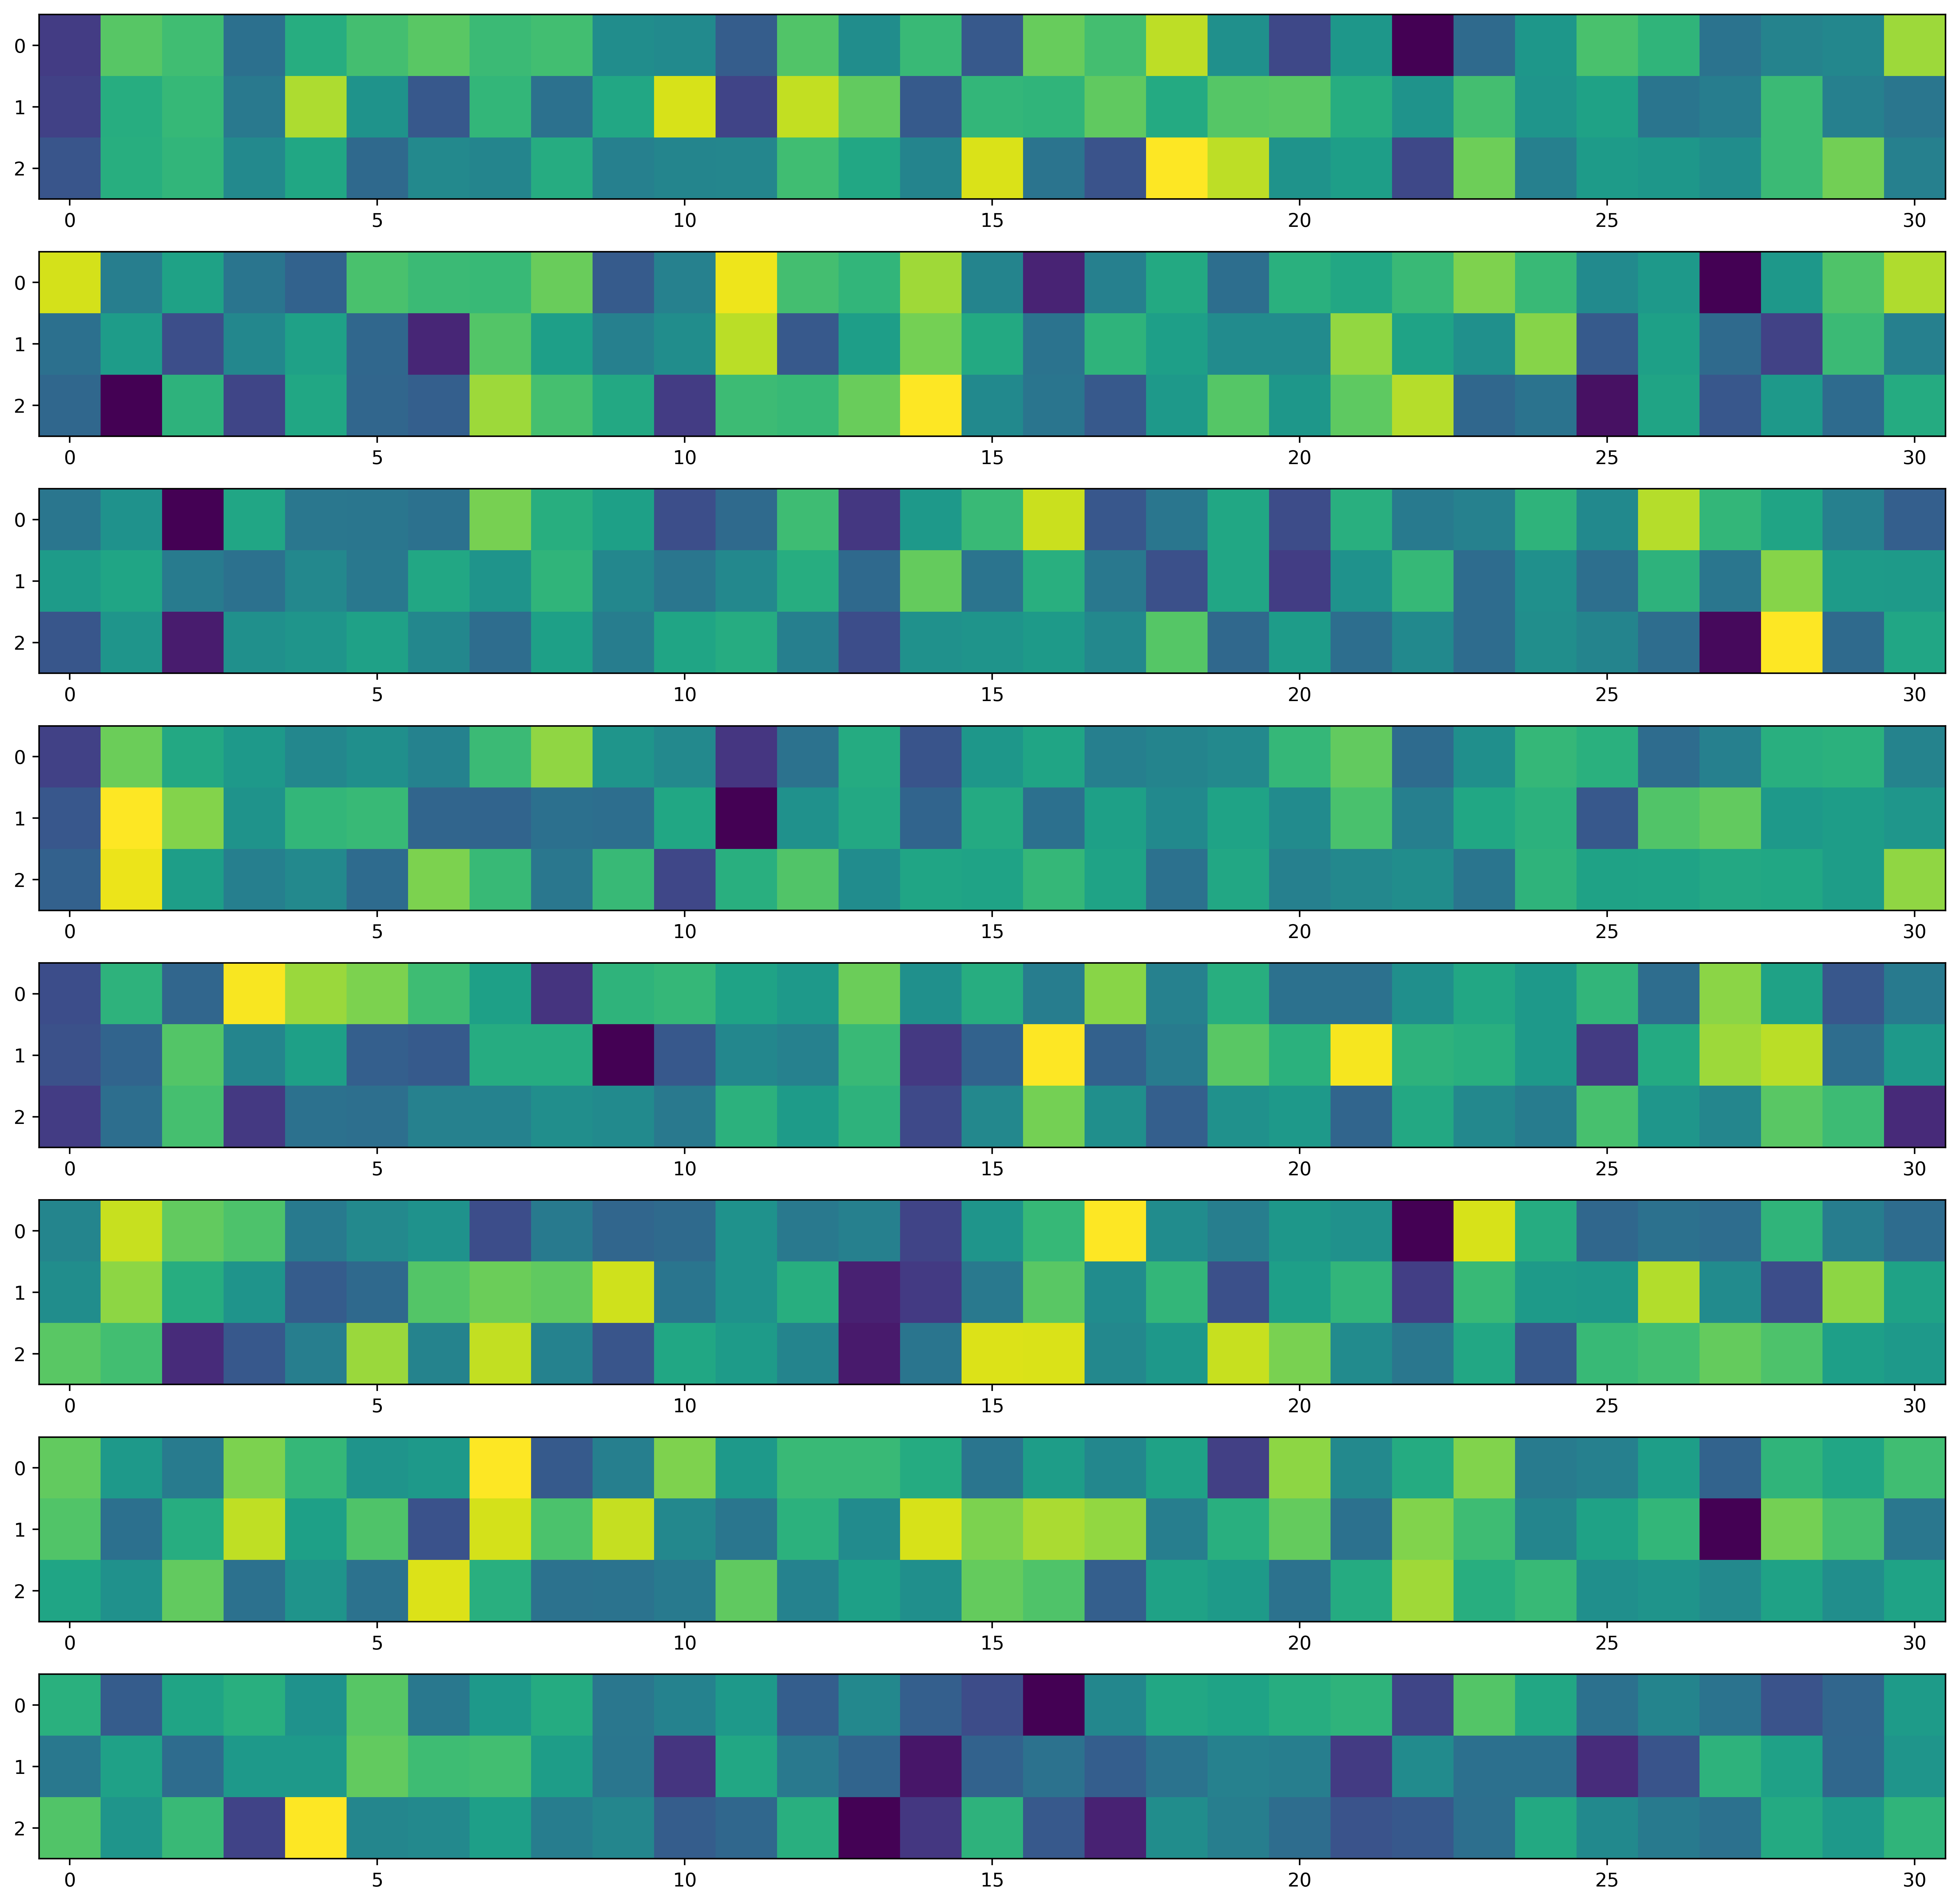

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(18,18),dpi=500)
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.imshow(w[0][:,:,i])

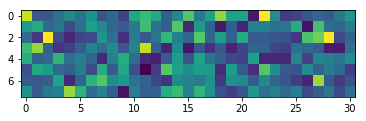

In [41]:
norm1=np.linalg.norm(w[0],axis=0)

plt.imshow(norm1.T)

In [42]:
maxind=np.argmax(norm1.T,axis=1)

np.array(feature_names)[maxind+2]

array(['ankle_acc16g_x', 'chest_acc16g_z', 'hand_acc16g_x', 'chest_temp',
       'hand_acc16g_y', 'ankle_acc16g_x', 'ankle_gyro_z', 'hand_acc16g_z'],
      dtype='<U14')